# graph of words
### referencia  http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=907E7B3B0E507B2DDF531A314D215114?doi=10.1.1.348.6172&rep=rep1&type=pdf

In [7]:
import ast
import re
from nltk import sent_tokenize
import spacy
nlp = spacy.load('en')
import numpy as np
import networkx as nx
import random
import operator
import itertools
import matplotlib.pyplot as plt
from nltk.corpus import stopwords # stopwords de nltk 
stop_words = set(stopwords.words('english'))

### clean text - elegimos si filtramos los textos para dejar unicamente sustantivos (comunes + propios) y adjetivos o si filtramos solo stop_words

In [49]:
# filter_nouns_adj indica el tipo de filtrado
# True dejamos sustantivos (comunes y propios) y adjetivos
# False filtramos solo stopwords

def clean(text,filter_nouns_adj):
    sentences=sent_tokenize(text)
    sentences=[nlp(sentence) for sentence in sentences]
    
    if filter_nouns_adj==True:
        sentences=[[token.lemma_ for token in sentence if token.pos_=='NOUN' or token.pos_=='ADJ' or token.pos_=='PROPN'] for sentence in sentences]
    else:
        sentences=[[token.lemma_ for token in sentence] for sentence in sentences]

    text=[item for sublist in sentences for item in sublist]
    text=[word for word in text if not word in stop_words]
    return text

In [63]:
text='the cat killed the dog with a knife. The lion killed the cat with a hummer'
clean(text,True)

['cat', 'dog', 'knife', 'lion', 'cat', 'hummer']

### graph of words

In [64]:
# K es el largo de la ventana
# filter_nouns_adj indica el tipo de filtrado
def graph_weighted(text,K,filter_nouns_adj):
    text=clean(text,filter_nouns_adj)
    unique_words=list(set(text))
    G=nx.Graph()
    for word in unique_words:
        G.add_node(word)
    for word in text: ## recorremos el texto y encontramos los indices de todas las aparicions de word (index_word)
        index_word=[index for index, value in enumerate(text) if value == word]
        ## ahora buscamos las palabras vecinas en una ventana de largo K (hacia adelante)
        for index in index_word:
            for k in range(1,K+1):
                if index+k in range(len(text)):
                    if G.has_edge(text[index],text[index+k])==False:
                        G.add_edge(text[index],text[index+k],weight=1)
                    else:
                        x=G[text[index]][text[index+k]]['weight']
                        G[text[index]][text[index+k]]['weight']=x+1
    
    return G

In [65]:
graph_weighted(text,2,False)

### Keywords a partir de graph of words. Se utiliza pagerank como algoritmo para encontrar nodos importantes

In [66]:
# K es el largo de la ventana
# filter_nouns_adj indica el tipo de filtrado
# number_keywords indica el numero de keywords
def keywords_pagerank(text,number_keywords,filter_nouns_adj,K):
    G=graph_weighted(text,K,filter_nouns_adj)
    keywords=nx.pagerank(G, alpha=0.85, weight='weight')
    return list(list(zip(*sorted(keywords.items(), key=operator.itemgetter(1),reverse=True)))[0][:number_keywords])
        

In [67]:
keywords_pagerank(text,4,True,2)

['cat', 'knife', 'lion', 'dog']

### visualizacion del subgrafo de keywords

In [68]:
def visualization(text,number_keywords,filter_nouns_adj,K):
    G=graph_weighted(text,K,filter_nouns_adj)
    keywords=nx.pagerank(G, alpha=0.85, weight='weight')
    list_keywords=keywords_pagerank(text,number_keywords,filter_nouns_adj,K)
    G = G.subgraph(list_keywords)
    #G=nx.minimum_spanning_tree(G) ## se podria 'podar' un poco el grafo 
    pos = nx.spring_layout(G)
    labels={i:i for i in G.nodes}
    nx.draw_networkx_nodes(G, pos, G.nodes, node_size = [keywords[k] * 10000 for k in G.nodes],node_color='r')
    nx.draw_networkx_edges(G, pos, alpha=0.5,width=0.5,edge_color='k')
    nx.draw_networkx_labels(G,pos,labels,font_size=12)
    plt.axis('off')
    #plt.savefig('keywords.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
    plt.show()

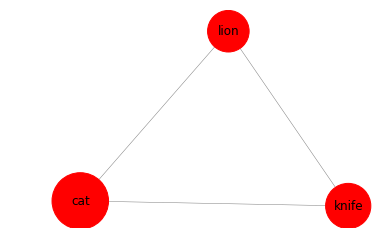

In [69]:
visualization(text,3,True,2)

### ejemplo en una intro de CELL

In [70]:
data = open('corpus_cell.json','r')
data_cell=data.read()
data_cell = ast.literal_eval(data_cell)
introductions=[' '.join(item['introduction']) for item in data_cell]
introductions=[re.sub("[\(\[].*?[\)\]]", "", item) for item in introductions]
introductions=[x for x in introductions if len(x)>0]

text=introductions[0]

In [71]:
keywords_pagerank(text,5,True,4)

['virus', 'zika', 'diagnostic', 'sensor', 'detection']

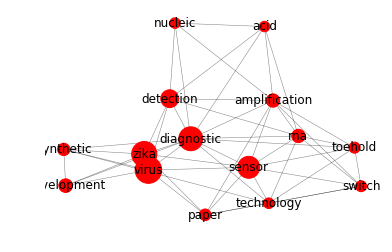

In [73]:
visualization(text,15,True,4)